## Проект для Некрасовской библиотеки
## Некрасовка Daily

**Задача:** Реализовать автоматическое создание голосовой радио-передачи по мотивам одной или нескольких газет из архивов библиотеки им. Некрасова на заданную дату.

Для начала установим Yandex Cloud ML SDK и несколько других полезных библиотек:

In [1]:
%pip install --quiet yandex-cloud-ml-sdk yandex-speechkit==1.5.0 telebot==0.0.5
%pip install --upgrade --quiet pydantic


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


## Датасет

Для решения задачи вам предоставлен датасет, содержащий статьи из нескольких газет за 1934-39 годы. Чтобы получить доступ к нему, добавьте в проект Datasphere датасет **newspapers**

In [2]:
!ls /home/jupyter/datasphere/datasets/newspapers

newspapers1934-39.json


Загрузим датасет в память:

In [3]:
import pandas as pd
df = pd.read_json("/home/jupyter/datasphere/datasets/newspapers/newspapers1934-39.json")
df

newspaper_year  ...                                newspaper_page_text
0                1934  ...  ПРОЛЕТАРИЙ ВСЕХ`СТРАН, СОЕЛИНЯЙТЕСЬ,\n\t\tПОНЕ...
1                1934  ...  СЕГОДНЯ |\n\t=== | января\n\tМосжилтрест об’ед...
2                1934  ...  _ '>ЗЕЛО\nБыло —\nЗАНЯТНО«\n\tПО КНИЖНЫМ\nМАГА...
3                1934  ...  отеавиовый звуковой к. ВНИИ ГЛАНИ Ю ДЛЯ ОБСЛУЖ...
4                1934  ...  НИ ВСЕХ СТРАН. СОЕДИНЯЙТЕСЬ!\n\tЯНВАРЯ 1934 г....
...               ...  ...                                                ...
15913            1939  ...                                               None
15914            1939  ...                                               None
15915            1939  ...                                               None
15916            1939  ...                                               None
15917            1939  ...                                               None

[15918 rows x 6 columns]

Добавим несколько дополнительных полей:

In [4]:
df["newspaper"] = df["newspaper_title"].apply(lambda x: x.split('/')[0])
df["year"] = df["newspaper_title"].apply(lambda x: x.split('/')[1])

Посмотрим на распределение количества записей по годам и газетам:

In [5]:
df.groupby('newspaper').count().iloc[:,:1]

newspaper_year
newspaper                          
Вечерняя Москва                5644
Литературная газета            2078
Правда                         8196

In [6]:
df.groupby('newspaper_year').count().iloc[:,:1]

newspaper_date
newspaper_year                
1934                      2364
1935                      1938
1936                      1352
1937                      3092
1938                      3556
1939                      3616

У некоторых записей нет распознанного текста статьи. Сколько их?

In [7]:
(df['newspaper_page_text'].isna().sum())/len(df)

0.3019851740168363

Посмотрим на типовой текст статьи:

In [8]:
sample = df.iloc[0,-3]
print(sample)

ПРОЛЕТАРИЙ ВСЕХ`СТРАН, СОЕЛИНЯЙТЕСЬ,
		ПОНЕДЕЛЬЧИК
ЯНВАРЯ 1934 г.
№: 1 (3630)
	Цена 189 коп.
	1955 ГОД
„НЕ ОПРАВДАЛ.
НАДЕЖД...
	Обэмняемые onpanga-
	(«Юманиеге»).
	Mm CBETAOB
- 19383—
1934
	H STUEA, не как прежде;
В образе старого деда,
Не мзаденец сменяет ето,
Как в старинном журнале, —
Комсомолец сменил комсомольца
На фронте победы —
Два литейньика рядом
Стоят. у расплавленной стали.
	Мьг не молодость назму

В двенеднать часов провожаем,
Мы не старость найдем

На пороге невого года —
Мы, как в пвотиклом году,
`Из-под снега шумим урожаем,
Мы хоровую в мире
Устанавливаем погоду.
	Над стареющим миром,

Над этой равниной седой

Дай мне руку, товаринт,
Поцкунать твой пульс молодой!
Ты крепок — ты выдержить
Вмёсте с моим поколеньем
Сорока атмосфев

И одной стратосферы лавленье...
	Новый год по равнинам
‚ПНровосит снегов торжество —
Как Димитров, спокойно,
Товарин взгляни на него!
Пусть шумит новый год

И январскою стужей тудит —
На шестнаднать птатов

Мы проходим его впереди!
Откровенная п

Видно, что это результат скана, качество которого не идеально. Причем это скан не отдельной статьи, а целой газетной полосы.

Исходное изображение газеты также доступно:

In [9]:
url = df.iloc[0]['origin_img']
url

'http://electrohelp.ebook.nekrasovka.ru/books/newspaper/113941/0001.jpg'

### Yandex OCR в облаке

В облаке доступно много интеллектуальных сервисов. В их числе - распознавание текста. Для вызова таких сервисов необходимо делать это от имени некоторого **сервисного аккаунта**.

В нашем случае, в секретах DataSphere уже лежит ключ `api_key` от сервисного аккаунта, которым можно пользоваться.

Большинство сервисов облака доступны через REST/gRPC API. Определим методы для вызова REST API с передачей нужных заголовков

In [10]:
import os
import requests

folder_id = os.environ['folder_id']
api_key = os.environ['api_key']

def call_api(url, data):
    headers = { "Authorization" : f"Api-Key {api_key}" }
    return requests.post(url, json=data, headers=headers).json()

def call_api_get(url, data):
    headers = { "Authorization" : f"Api-Key {api_key}" }
    return requests.get(url, headers=headers).json()

Для вызова OCR используем вот такую функцию:

In [11]:
from PIL import Image
from io import BytesIO
import base64

def ocr(img):
    buffer = BytesIO()
    img.save(buffer,format="JPEG")
    myimage = buffer.getvalue()

    j = {
      "mimeType": "JPEG",
      "languageCodes": ["*"],
      "model": "page",
      "content": base64.b64encode(myimage).decode('utf-8')
    }
    res = call_api("https://ocr.api.cloud.yandex.net/ocr/v1/recognizeText",j)
    return res

Откроем изображение странички выше

In [12]:
response = requests.get(url)
img = Image.open(BytesIO(response.content))

Передавать на OCR весь текст - слишком тяжелая задача для сервиса, поэтому вырежем кусочек изображения, содержищий отдельную статью:

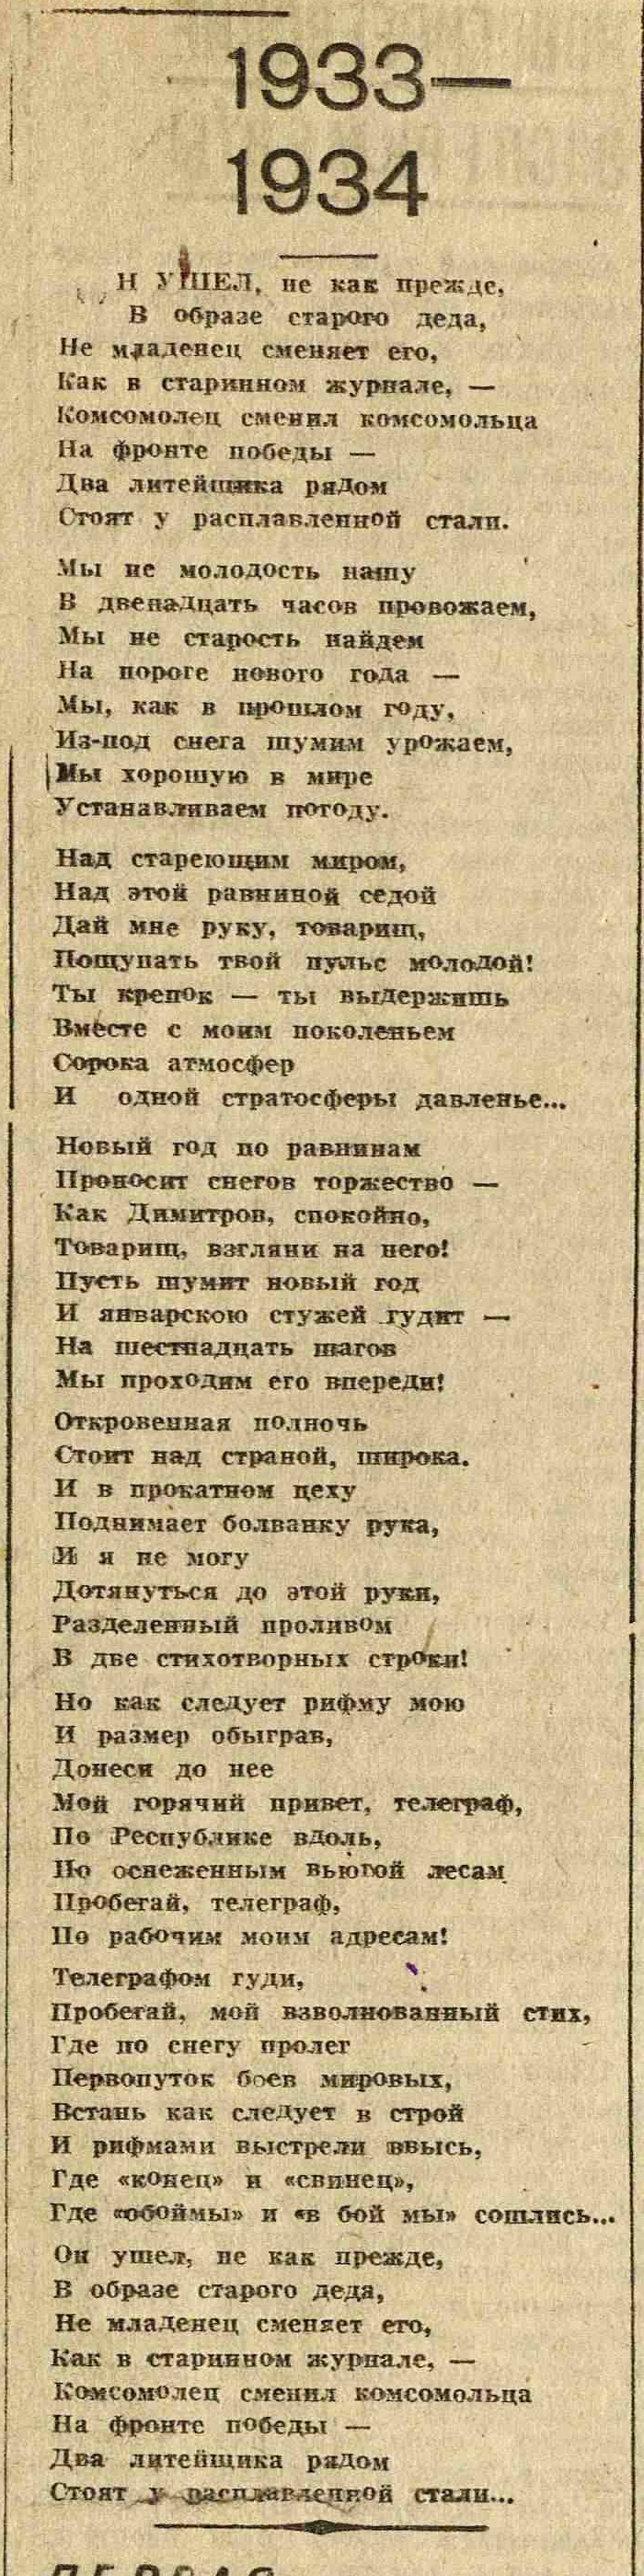

In [13]:
im = img.crop((2900,300,3600,3100))
im

In [14]:
ocr(im)

{'result': {'textAnnotation': {'width': '700',
   'height': '2800',
   'blocks': [{'boundingBox': {'vertices': [{'x': '202', 'y': '57'},
       {'x': '202', 'y': '222'},
       {'x': '501', 'y': '222'},
       {'x': '501', 'y': '57'}]},
     'lines': [{'boundingBox': {'vertices': [{'x': '207', 'y': '57'},
         {'x': '207', 'y': '107'},
         {'x': '501', 'y': '107'},
         {'x': '501', 'y': '57'}]},
       'text': '1933-',
       'words': [{'boundingBox': {'vertices': [{'x': '207', 'y': '46'},
           {'x': '207', 'y': '118'},
           {'x': '501', 'y': '118'},
           {'x': '501', 'y': '46'}]},
         'text': '1933-',
         'entityIndex': '-1',
         'textSegments': [{'startIndex': '0', 'length': '5'}]}],
       'textSegments': [{'startIndex': '0', 'length': '5'}],
       'orientation': 'ANGLE_0'},
      {'boundingBox': {'vertices': [{'x': '202', 'y': '169'},
         {'x': '202', 'y': '222'},
         {'x': '445', 'y': '222'},
         {'x': '445', 'y': '169

Видим, что распозналить отдельные фрагменты текста с координатами. Можно взять также весь распознанный текст:

In [15]:
print(ocr(im)['result']['textAnnotation']['fullText'])

1933-
1934
н ушел, не как прежде,
образе старого деда,
Не младенец сменяет его,
Как в старинном журнале, -
Комсомолец сменил комсомольца
На фронте победы -
Два литейшика рядом
Стоят у расплавленной стали.
Мы не молодость нашу
В двепадцать часов провожаем,
Мы не старость найдем
На пороге нового года
Мы, как в прошлом году,
Из-под снега шумим урожаем,
Мы хорошую в мире
Устанавливаем потоду.
Над стареющим миром,
Над этой равниной седой
Дай мне руку, товариш,
Пощупать твой пульс молодой!
Ты крепок - ты выдержишь
Вместе с моим поколеньем
Сорока атмосфер
И одной стратосферы давленье…
Новый год по равнинам
Проносит снегов торжество -
Как Димитров, спокойно,
Товарищ, взгляни на него!
Пусть шумит новый год
И январскою стужей гудит
На шестнадцать шагов
Мы проходим его впереди!
Откровенная полночь
Стоит над страной, широка.
И в прокатном цеху
Поднимает болванку рука,
И я не могу
Дотянуться до этой руки,
Разделенный проливом
В две стихотворных строки!
Но как следует рифму мою
И размер обыграв,
Дон

Что скажете, получилось лучше или хуже распознанного библиотекой текста? Как можно автоматически сравнить качество?

## Задача выделения статей

Одна из задач, которые стоят в рамках проекта, состоит в выделении текстов отдельных статей. В исходном датасете содержатся распознанные **газетные страницы**, и в них достаточно непросто понять, где кончается одна статья и начинается другая. Учтите также, что статьи могут переноситься с одной страницы на другую (*продолжение на стр 13...*).

Как можно решить задачу разбивки газеты на статьи?
* Анализируя распознанные текст исходной полосы из датасета
* Анализируя исходное изображение газетного листа с помощью специальной модели сегментации
* Анализируя координаты распознанных фрагментов текста на выходе из OCR

Во всех случаях также встанет задача объединения разбитых на фрагменты по разным листам статей.

## Большие языковые модели

Сложные задачи можно попробовать решать с помощью больших языковых моделей. В облаке Yandex Cloud доступны к использованию [несколько разных языковых моделей](https://yandex.cloud/ru/docs/foundation-models/concepts/yandexgpt/models). Удобнее всего для работы с моделями использовать Yandex Cloud ML SDK:

In [16]:
import os
from yandex_cloud_ml_sdk import YCloudML

folder_id = os.environ['folder_id']
api_key = os.environ['api_key']

sdk = YCloudML(folder_id=folder_id, auth=api_key)

# Раскомментируйте, если хотите подробнее смотреть, что делает SDK
#sdk.setup_default_logging(log_level='DEBUG')

model = sdk.models.completions("yandexgpt", model_version="rc")

In [17]:
from IPython.display import Markdown, display
def printx(string):
    display(Markdown(string))
    
printx(model.run("Расскажи анекдот").text)

Два друга разговаривают:

— У меня теперь всё по науке: купил увлажнитель воздуха, мониторю качество воздуха, температуру и влажность в квартире, подбираю оптимальные параметры.

— И как, помогло?

— Конечно! Раньше думал, что у меня аллергия на кота, а оказалось — просто пыль в воздухе. Теперь и кот в порядке, и я!

In [18]:
#sample = df.iloc[0,-3]
sample = df.iloc[1,-3]

prompt = """
Ты - газетный редактор, которому на вход подается распознанный с помощью OCR текст газетной полосы.
Твоя задача:
* вернуть исходный текст с минимальными изменениями
* исправить в этом тексте опечатки
* разбить этот текст на отдельные статьи, руководствуясь форматированием и смыслом текста
Верни ответ в виде списка отдельных статей.
"""
model.run([
    {
        "role" : "system",
        "text" : prompt
    },
    {
        "role" : "user",
        "text" : sample
    }])

GPTModelResult(alternatives=(Alternative(role='assistant', text='**Статья 1:**\n\nМосжилтрест объединяет крупные жилые дома столицы. Он является одной из крупнейших жилищных организаций, что подчёркивает его роль в борьбе за сохранение и лучшую эксплуатацию жилищного фонда Москвы.\n\n200 домов Мосжилтреста — это лучшее, чем вообще располагает Моссовет в своём жилфонде. Сюда входят дома четырёх- и пятиэтажные, оборудованные лифтами, паровым отоплением, газом, насчитывающие до 5 тысяч метров жилой площади. Таковы дома по улице Горького, 33, по Арбату, 35, и др.\n\nПовторяем, мосжилтрестовские дома — лучшие. Вернее, они были лучшими, ибо многие из них в настоящее время находятся в довольно плачевном состоянии. Котельные устарели, отопление в связи с этим работает с перебоями, лифты на 50% бездействуют, так как находятся в состоянии непригодности. Квартиры нереуплотнены, в отдельных случаях заселены места общего пользования — кухни, ванные, коридоры (Ново-Басманная, 31, Никитский бульвар 1

В данном случае кажется, что вернулся не весь текст. Надо с этим разобраться:
* Увеличить количество генерируемых токенов max_tokens, установив их по длине входного текста
* Подавать текст на вход по частям - в этом случае не очень понятно, как его разбивать

Языковую модель можно использовать для многих различных целей, например, извлечения всех основных тем из номера:

In [19]:
prompt = """
Ты - газетный редактор, которому на вход подается распознанный с помощью OCR текст газетной полосы.
Твоя задача: прочитать весь текст и вернуть список всех основных тем, которые были затронуты в этом
номере.
"""
x = model.run([
    {
        "role" : "system",
        "text" : prompt
    },
    {
        "role" : "user",
        "text" : sample
    }])
print(x.text)

1. Состояние и проблемы жилищного фонда Мосжилтреста.
2. Ремонт и модернизация московской радиосети.
3. Эксперименты с пригородными пассажирами М.-Ниж. ж. д.
4. Строительство и использование портального крана в Москве.
5. Проблемы с зимней одеждой в магазинах.
6. Развитие маршрутных карт для автомобилистов.
7. Увеличение подачи воды и строительство новых водопроводных линий.
8. Планы по строительству метрополитена и других крупных объектов.
9. Улучшение условий жизни рабочих и служащих в Москве.


In [20]:
topics = [t[t.find('.')+1:].strip() for t in x.text.split('\n')]
topics

['Состояние и проблемы жилищного фонда Мосжилтреста.',
 'Ремонт и модернизация московской радиосети.',
 'Эксперименты с пригородными пассажирами М.-Ниж. ж. д.',
 'Строительство и использование портального крана в Москве.',
 'Проблемы с зимней одеждой в магазинах.',
 'Развитие маршрутных карт для автомобилистов.',
 'Увеличение подачи воды и строительство новых водопроводных линий.',
 'Планы по строительству метрополитена и других крупных объектов.',
 'Улучшение условий жизни рабочих и служащих в Москве.']

Также для получения списка тем можно использовать **структурированный ответ**. В этом случае мы говорим модели, какого формата выход от неё ожидается.

In [21]:
from pydantic import BaseModel
from typing import List

class Topics(BaseModel):
    topics : List[str]
    
prompt = """
Ты - газетный редактор, которому на вход подается распознанный с помощью OCR текст газетной полосы.
Твоя задача: прочитать весь текст и вернуть список всех основных тем, которые были затронуты в этом
номере.
"""
x = model.configure(response_format=Topics).run([
    {
        "role" : "system",
        "text" : prompt
    },
    {
        "role" : "user",
        "text" : sample
    }])
print(x.text)

{"topics": ["Состояние и проблемы домов Мосжилтреста", "Ремонт и восстановление домов Мосжилтреста", "Препятствия в работе Мосжилтреста", "Расширение культурных очагов в домах Мосжилтреста", "Проблемы с московской радиосетью", "Реорганизация московской радиосети", "Эксперименты с пригородными пассажирами М.-Ниж. ж. д.", "Строительство пятиэтажных домов с помощью портала крана", "Увеличение количества разговоров на московских телефонных станциях", "Традиции и инновации в торговле", "Пути улучшения работы почтовых отделений", "Планы по развитию метрополитена и других объектов инфраструктуры", "Рост подачи воды в Москве", "Работы по строительству канала Москва-Волга", "Развитие канализации в Москве", "Улучшение условий жизни рабочих и служащих в Москве", "Увеличение числа школ и других социальных объектов", "Расширение сети общественного питания", "Планы по улучшению коммунального хозяйства и жилищного строительства", "Реконструкция и развитие промышленных предприятий в Москве"]}


In [22]:
z = Topics.model_validate_json(x.text)
print(z.topics)

['Состояние и проблемы домов Мосжилтреста', 'Ремонт и восстановление домов Мосжилтреста', 'Препятствия в работе Мосжилтреста', 'Расширение культурных очагов в домах Мосжилтреста', 'Проблемы с московской радиосетью', 'Реорганизация московской радиосети', 'Эксперименты с пригородными пассажирами М.-Ниж. ж. д.', 'Строительство пятиэтажных домов с помощью портала крана', 'Увеличение количества разговоров на московских телефонных станциях', 'Традиции и инновации в торговле', 'Пути улучшения работы почтовых отделений', 'Планы по развитию метрополитена и других объектов инфраструктуры', 'Рост подачи воды в Москве', 'Работы по строительству канала Москва-Волга', 'Развитие канализации в Москве', 'Улучшение условий жизни рабочих и служащих в Москве', 'Увеличение числа школ и других социальных объектов', 'Расширение сети общественного питания', 'Планы по улучшению коммунального хозяйства и жилищного строительства', 'Реконструкция и развитие промышленных предприятий в Москве']


## Ассистенты и Retrieval-Augmented Generation

Интересным расширением LLM является возможность добавить знания в формате Retrieval-Augmented Generation. Для реализации этого можно использовать API ассистентов в Yandex Cloud.

Попробуем загрузить материалы из одной газеты в текстовую базу знаний. Возьмём какую-то одну дату:

In [23]:
fragment = df[(df['newspaper']=='Вечерняя Москва') & (df['newspaper_date']=='01-01-1934')]
fragment

newspaper_year newspaper_date  ...        newspaper  year
0            1934     01-01-1934  ...  Вечерняя Москва  1934
1            1934     01-01-1934  ...  Вечерняя Москва  1934
2            1934     01-01-1934  ...  Вечерняя Москва  1934
3            1934     01-01-1934  ...  Вечерняя Москва  1934

[4 rows x 8 columns]

Загружаем все фрагменты из одной газеты в облако:

In [24]:
files = []
for i,r in fragment.iterrows():
    id = sdk.files.upload_bytes(
            r['newspaper_page_text'].encode(), ttl_days=1, expiration_policy="static")
    files.append(id)

Создаём индекс на базе этих файлов:

In [25]:
from yandex_cloud_ml_sdk.search_indexes import (
    StaticIndexChunkingStrategy,
    HybridSearchIndexType,
    ReciprocalRankFusionIndexCombinationStrategy,
)

op = sdk.search_indexes.create_deferred(
    files,
    index_type=HybridSearchIndexType(
        chunking_strategy=StaticIndexChunkingStrategy(
            max_chunk_size_tokens=1000, chunk_overlap_tokens=100
        ),
        combination_strategy=ReciprocalRankFusionIndexCombinationStrategy(),
    ),
)
index = op.wait()

Создаём ассистента, предназначенного для ответов на вопросы по статье:

In [26]:
search_tool = sdk.tools.search_index(index)

def create_thread():
    return sdk.threads.create(ttl_days=1, expiration_policy="static")

def create_assistant(model, tools=None):
    kwargs = {}
    if tools and len(tools) > 0:
        kwargs = {"tools": tools}
    return sdk.assistants.create(
        model, ttl_days=1, expiration_policy="since_last_active", **kwargs
    )

assistant = create_assistant(model, tools=[search_tool])
thread = create_thread()

instruction = """
Ты - опытный газетный редактор. У тебя в памяти есть все статьи из газеты за некоторую дату.
Твоя задача - отвечать пользователю на вопросы, суммаризировать фрагменты текста и писать
короткие заметки по мотивам содержимого статей.
"""

_ = assistant.update(instruction=instruction)

Попросим ассистента суммаризовать все содержимое газеты по темам, которые мы извлекли на предыдущем этапе:

In [27]:
for x in topics[:3]:
    thread.write(f"Напиши короткую заметку по материалам газемы на тему: {x}")
    run = assistant.run(thread)
    result = run.wait()
    printx(f"""
## {x}
    
{result.text}
    """)


## Состояние и проблемы жилищного фонда Мосжилтреста.
    
**Состояние и проблемы жилищного фонда Мосжилтреста**

Мосжилтрест объединяет крупные дома столицы и является одной из крупнейших жилищных организаций. Однако многие дома треста находятся в плачевном состоянии: котельные устарели, отопление работает с перебоями, лифты неисправны.

Трест сталкивается с нехваткой оборотных средств для обеспечения плана ремонта на 1934 год стройматериалами и автомашинами. Это затрудняет вывоз мусора и доставку топлива.

Мосжилтрест ставит перед собой задачу в кратчайшие сроки ликвидировать перебои в отоплении и предупредить аварии. Для успешного выполнения этой задачи необходима помощь общественности и устранение ведомственной недоговорённости.
    


## Ремонт и модернизация московской радиосети.
    
**Ремонт и модернизация московской радиосети**

Московская радиосеть технически износилась, что приводит к перебоям в работе радиолиний. В 1934 году радиослужба планирует провести капитальный ремонт сети и оборудования у абонентов.

Коллегия Наркомовязи постановила превратить радиотрансляционную сеть Москвы в лучшую и показательную сеть страны. Для этого будут установлены понижающие трансформаторы на всех абонентских вводах, а заявки о повреждениях будут приниматься радиостолом с 6 часов утра до конца ночных передач.

Участковые монтёры и техники начнут регулярные обходы магистралей и квартир абонентов. Размер зарплаты теперь будет обратно пропорционален количеству повреждений и времени молчания радиоточек в их участке.
    


## Эксперименты с пригородными пассажирами М.-Ниж. ж. д.
    
**Эксперименты с пригородными пассажирами М.-Ниж. ж. д.**

М.-Ниж. ж. д. проводит эксперименты по «акклиматизации» пригородных пассажиров, убирая крытые помещения на станциях и ограничивая освещение. 

Пассажиры сталкиваются с неудобствами: им приходится ждать транспорта под дождём, снегом и ветром, а также передвигаться в темноте. 

Эти меры, по всей видимости, направлены на «закаливание» пассажиров. Однако последние недовольны экспериментами и просят прекратить их, отправляя заявления в соответствующие инстанции.
    

## Синтезируем речь

Чтобы получить радиопередачу, научимся синтезировать голос. Мы будем использовать Yandex SpeechKit.

In [28]:
from speechkit import model_repository, configure_credentials, creds

# Аутентификация через API-ключ.
configure_credentials(
   yandex_credentials=creds.YandexCredentials(
      api_key=api_key
   )
)

def synthesize(text,voice='jane'):
   model = model_repository.synthesis_model()

   # Задайте настройки синтеза.
   model.voice = voice

   # Синтез речи и создание аудио с результатом.
   result = model.synthesize(text, raw_format=False)
   return result

res = synthesize('Привет, как ты?')
res

Пройдёмся по треду, и синтезируем отдельные заметки оттуда:

In [29]:
from tqdm.auto import tqdm

spk = True
spch = []
res = None
for msg in tqdm(list(thread)[::-1]):
    if msg.author.role=="ASSISTANT":
        r = synthesize(msg.text,voice='jane' if spk else 'zahar')
        spk = not spk
        spch.append((msg.text,r))
        if res:
            res += r
        else:
            res = r
res

100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


## Делаем телеграм-интерфейс

Для того, чтобы показать результаты пользователю, можем использовать телеграм. Для этого используем библиотеку `telebot`.

In [33]:
import telebot
import random
import io

telegram_token = os.environ['tg_token']

bot = telebot.TeleBot(telegram_token)

# Обработчик команды /start
@bot.message_handler(commands=['start'])
def start(message):
    # Отправляем приветственное сообщение
    text,snd = random.choice(spch)
    bot.send_message(message.chat.id,text,parse_mode='Markdown')
    audio_buffer = io.BytesIO()
    snd.export(audio_buffer, format="ogg", codec="libopus")
    audio_buffer.seek(0)
    bot.send_voice(message.chat.id, audio_buffer)


# Запуск бота
print("Бот готов к работе")
bot.polling(none_stop=True)

Бот готов к работе


## Удаляем лишнее

In [36]:
for thread in sdk.threads.list():
    try:
        print(f" + deleting thread id={thread.id}")
        thread.delete()
    except:
        pass
        
for assistant in sdk.assistants.list():
    print(f" + deleting assistant id={assistant.id}")
    assistant.delete()
    
for index in sdk.search_indexes.list():
    print(f" + deleting index id={index.id}")
    index.delete()
    
print(" + Deleting files")
for file in sdk.files.list():
    print(f" + deleting file id={file.id}")
    file.delete()

 + deleting thread id=fvt57m6ndcabj95mdb0u
 + deleting thread id=fvtu4shj4jd8vt0ns2eb
 + deleting thread id=fvtheeddupugt2vhpnvr
 + deleting thread id=fvtrvii64qdol0rsupks
 + deleting thread id=fvtm31ie8304q3s7iljj
 + deleting index id=fvtrc0f6jc74pje10dea
 + deleting index id=fvt1jj7amvbfsjleikug
 + Deleting files
 + deleting file id=fvts6e6r7ub828m63b1j
 + deleting file id=fvtgc5us32taf48fs8fm
 + deleting file id=fvtibesul66epaaip5jv
 + deleting file id=fvt74j0efppjvk8qvros
 + deleting file id=fvt0srp58dgqsicvnbds
 + deleting file id=fvthoro2bl6q2c5hah8s
 + deleting file id=fvtmif3rplcb3slhs5js
 + deleting file id=fvtu4ujnqkl138flsng8
